## More from arch

_This setup code is required to run in an IPython notebook_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.myuseq.cnf'})
conn = engine.connect()

In [3]:

import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_open, pct_high, pct_low, pct_close from USEQ_HIST where symbol="MS"
    and volume>0
     order by tradedate''',
    conn,
    index_col='tradedate'
)
df = pd.DataFrame(SQL_query, columns=["pct_open","pct_high","pct_low","pct_close"])

df.head()

,pct_open,pct_high,pct_low,pct_close
tradedate,,,,
2001-01-02,-1.26183,-0.075707,-12.93380,-8.99684
2001-01-03,-7.74441,5.682540,2.89855,16.04270
2001-01-04,17.74480,6.571870,19.18310,5.97443
2001-01-05,4.34118,-0.560601,-1.61901,-4.58902
2001-01-08,-5.28808,-4.791970,-3.37537,-1.47719


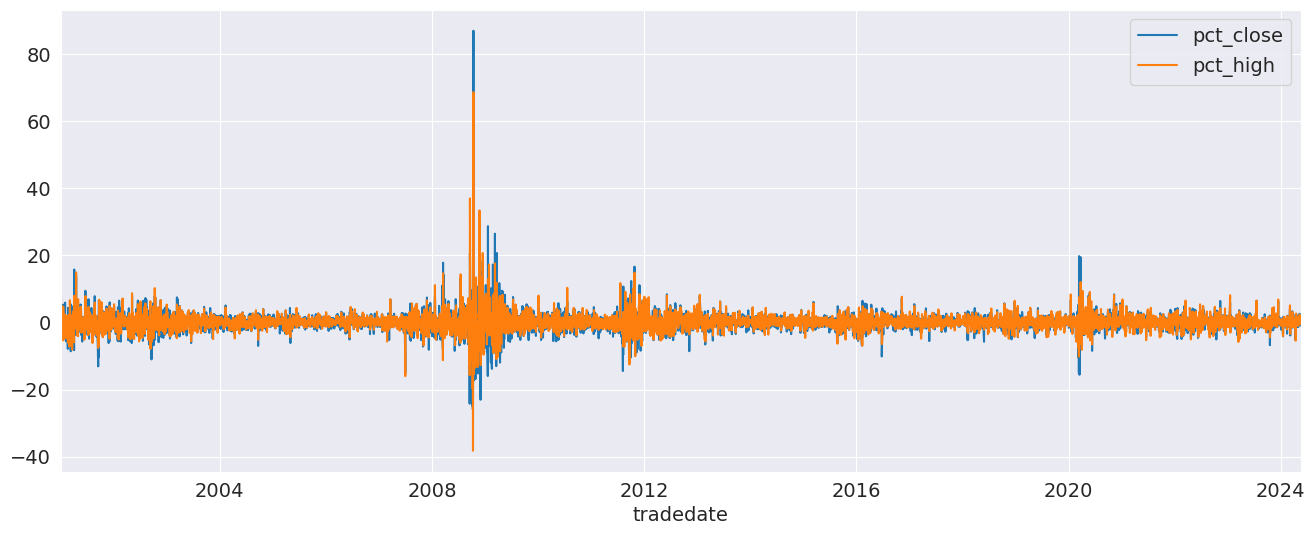

In [4]:
ax = plt.gca()
df.plot(y='pct_close', ax=ax)
df.plot(y='pct_high', ax=ax)
xlim = ax.set_xlim(df.index.min(), df.index.max())

In [5]:
from arch import arch_model

## GJR-Garch with Student's T

In [6]:
am = arch_model(df["pct_close"], p=1, o=1, q=1, dist="StudentsT", rescale=False)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 23032.341727190862
Iteration:     10,   Func. Count:     84,   Neg. LLF: 12409.9612894639
Iteration:     15,   Func. Count:    123,   Neg. LLF: 12403.245234786078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12403.240402976204
            Iterations: 18
            Function evaluations: 145
            Gradient evaluations: 18
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -12403.2
Distribution:      Standardized Student's t   AIC:                           24818.5
Method:                  Maximum Likelihood   BIC:                           24858.6
                                              No. Observations

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.


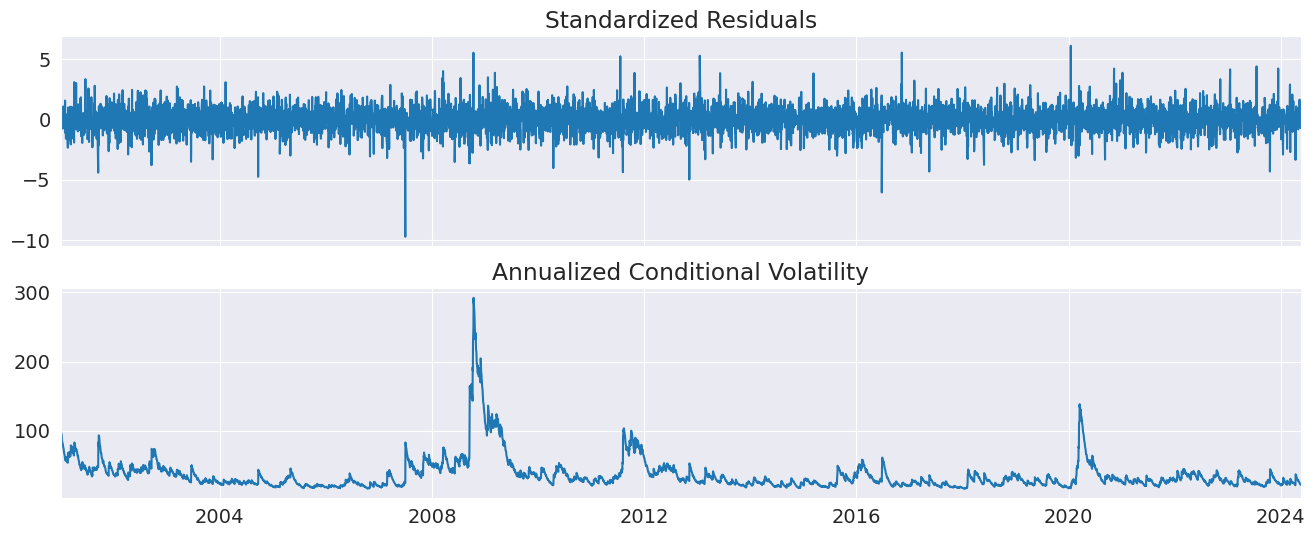

In [7]:
fig = res.plot(annualize="D")

## Parameters


In [8]:
res.params

mu          0.035278
omega       0.048656
alpha[1]    0.014642
gamma[1]    0.097670
beta[1]     0.929243
nu          6.191552
Name: params, dtype: float64

## Forecasts

In [9]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=10, reindex=False)
print(forecasts.residual_variance.iloc[-3:])


                 h.1
tradedate           
2024-05-17  0.035278
                h.01      h.02      h.03      h.04      h.05      h.06  \
tradedate                                                                
2024-05-17  1.870509  1.905548  1.940333  1.974864  2.009144  2.043175   

                h.07      h.08      h.09      h.10  
tradedate                                           
2024-05-17  2.076957  2.110494  2.143787  2.176837  


In [10]:
conn.close()